# NBA Playoff Prediction - Logistic Regression

This notebook implements logistic regression with regularization for predicting NBA playoff qualification.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = "./data/processed"
MODEL_PATH = "./models/logistic_regression"
RESULTS_PATH = "./results/logistic_regression"

os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)


In [2]:
# Load all 4 feature transformation versions
data_versions = {
    'baseline': ('scaled', 'Baseline (untransformed)'),
    'poly2': ('poly2', 'Polynomial degree 2'),
    'poly3': ('poly3', 'Polynomial degree 3'),
    'pca': ('pca', 'PCA (95% variance)')
}

# Load labels (same for all versions)
y_train = np.load('data/processed/y_train.npy')
y_val = np.load('data/processed/y_val.npy')
y_test = np.load('data/processed/y_test.npy')

# Load all versions
X_data = {}
for name, (suffix, desc) in data_versions.items():
    X_data[name] = {
        'train': np.load(f'data/processed/X_train_{suffix}.npy'),
        'val': np.load(f'data/processed/X_val_{suffix}.npy'),
        'test': np.load(f'data/processed/X_test_{suffix}.npy'),
        'desc': desc
    }
    print(f"{desc}: Train={X_data[name]['train'].shape}, Val={X_data[name]['val'].shape}, Test={X_data[name]['test'].shape}")

# Set X_train, X_val, X_test to baseline for compatibility (will be overridden in loops)
X_train = X_data['baseline']['train']
X_val = X_data['baseline']['val']
X_test = X_data['baseline']['test']


Baseline (untransformed): Train=(446, 27), Val=(120, 27), Test=(120, 27)
Polynomial degree 2: Train=(446, 405), Val=(120, 405), Test=(120, 405)
Polynomial degree 3: Train=(446, 4059), Val=(120, 4059), Test=(120, 4059)
PCA (95% variance): Train=(446, 13), Val=(120, 13), Test=(120, 13)


In [3]:
# Augment X with column of ones for bias term
def augment_X(X):
    ones = np.ones((X.shape[0], 1))
    return np.hstack([ones, X])

# Reshape y to column vectors
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)



In [4]:
# 1. Sigmoid function
def sigmoid(z):
    e_term = np.exp(-z)
    return 1/(1+e_term)


In [5]:
# 2. Hypothesis function
def hypothesis(X, w):
    Xw = np.dot(X, w)
    return sigmoid(Xw)


In [6]:
# 3. Log-likelihood function with regularization
def log_likelihood(X, y, w, lambda_reg=0):
    hyp = hypothesis(X, w)
    log_lik = np.sum(y * np.log(hyp + 1e-10) + (1 - y) * np.log(1 - hyp + 1e-10))
    
    # Add L2 regularization term (excluding bias term)
    if lambda_reg > 0:
        w_without_bias = w[1:].copy()  # Exclude bias term
        reg_term = -lambda_reg * np.sum(w_without_bias ** 2) / 2
        log_lik += reg_term
    
    return log_lik


In [7]:
# 4. Gradient Ascent function with regularization
def Gradient_Ascent(X, y, learning_rate, num_iters, lambda_reg=0, verbose=True):
    # We assume X has been augmented with a column of ones
    
    # Number of training examples
    N = X.shape[0]
    
    # Initialize w. Zeros vector of shape (X.shape[1], 1)
    w = np.zeros((X.shape[1], 1))
    
    # Initiating list to store values of likelihood after few iterations
    log_likelihood_values = []
    
    # Gradient Ascent with regularization
    for i in range(num_iters):
        # Compute hypothesis
        hyp = hypothesis(X, w)
        
        # Compute gradient (without regularization)
        gradient = np.dot(X.T, (y - hyp)) / N
        
        # Add L2 regularization to gradient (excluding bias term)
        # Note: regularization gradient is NOT divided by N
        if lambda_reg > 0:
            w_without_bias = w.copy()
            w_without_bias[0] = 0  # Don't regularize bias term
            gradient -= lambda_reg * w_without_bias
        
        # Update weights
        w = w + learning_rate * gradient
        
        # Compute log likelihood of seeing examples for current value of w
        if (i % 10) == 0:
            ll = log_likelihood(X, y, w, lambda_reg)
            log_likelihood_values.append(ll)
            if verbose:
                print(log_likelihood(X, y, w, lambda_reg))
    
    return w, log_likelihood_values


In [8]:
# 5. Predict class function
def predict_class(X, w, t):
    # Hypothesis calculation
    y_prob = hypothesis(X, w)
    # Get prediction based on whether prob is greater than threshold t
    y_pred = (y_prob >= t).astype(int)
    return y_pred


In [9]:
# 6. Precision and recall function
def precision_recall(y_hat, y, threshold):
    # y_hat is a 2d array, so we need to flatten it
    y_hat = y_hat.flatten()
    y = y.flatten()

    # Calculate false positive and false negative
    false_pos = np.sum((y_hat > threshold) & (y == 0))
    false_neg = np.sum((y_hat <= threshold) & (y == 1))
    
    # Calculate true positive and true negatives
    true_pos = np.sum((y_hat > threshold) & (y == 1))
    true_neg = np.sum((y_hat <= threshold) & (y == 0))

    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    
    return precision, recall


In [10]:
# 7. F1 score function
def f1_score(precision, recall):
    if (precision + recall) == 0:
        return 0
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1


In [11]:
# Hyperparameters
learning_rate = 0.01
num_iters = 10000
lambda_reg = 0.1  # Regularization strength (L2)

print("Training logistic regression with regularization...")
print(f"Learning rate: {learning_rate}, Iterations: {num_iters}, Lambda: {lambda_reg}")
print("-" * 60)

# Augment X_train with bias term
X_train_aug = augment_X(X_train)
X_val_aug = augment_X(X_val)
X_test_aug = augment_X(X_test)

# Train the model
w, log_likelihood_values = Gradient_Ascent(
    X_train_aug, 
    y_train, 
    learning_rate, 
    num_iters, 
    lambda_reg=lambda_reg,
    verbose=True
)

print("\nTraining completed!")


Training logistic regression with regularization...
Learning rate: 0.01, Iterations: 10000, Lambda: 0.1
------------------------------------------------------------
-305.19665470969994
-272.30364404983845
-248.44634984095657
-230.55272272172255
-216.67556277845998
-205.5921831076858
-196.5187159151101
-188.93696857171642
-182.49320086687442
-176.93849761764955
-172.09281783459986
-167.82270063599043
-164.02703825961314
-160.62774486394144
-157.56347828435818
-154.7853157109302
-152.25371070535738
-149.93630965517463
-147.80635679104773
-145.8415100510293
-144.02294882855378
-142.33469247373014
-140.76307325625183
-139.29632410318004
-137.92425271374174
-136.63798144930067
-135.42973785982275
-134.29268458915098
-133.2207801938493
-132.2086644437219
-131.25156316938842
-130.34520883646073
-129.48577386317353
-128.66981433343054
-127.89422224319053
-127.1561847930386
-126.45314953129083
-125.78279438029604
-125.14300175866838
-124.53183615513787
-123.94752462390191
-123.38843976312258
-1

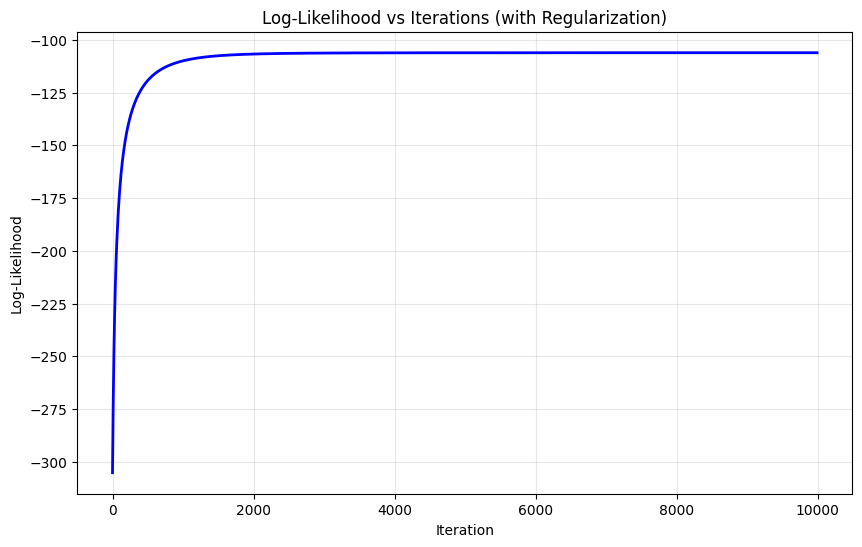

In [12]:
# Plot log-likelihood over iterations
plt.figure(figsize=(10, 6))
iterations = np.arange(0, num_iters, 10)
plt.plot(iterations, log_likelihood_values, 'b-', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Iterations (with Regularization)')
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
# Make predictions on all sets
threshold = 0.5

y_train_pred = predict_class(X_train_aug, w, threshold)
y_val_pred = predict_class(X_val_aug, w, threshold)
y_test_pred = predict_class(X_test_aug, w, threshold)

# Get probabilities
y_train_prob = hypothesis(X_train_aug, w)
y_val_prob = hypothesis(X_val_aug, w)
y_test_prob = hypothesis(X_test_aug, w)


In [14]:
# Compute metrics using custom functions
print("=" * 60)
print("EVALUATION METRICS")
print("=" * 60)

for name, y_true, y_pred, y_prob in [
    ("Training", y_train, y_train_pred, y_train_prob),
    ("Validation", y_val, y_val_pred, y_val_prob),
    ("Test", y_test, y_test_pred, y_test_prob)
]:
    print(f"\n{name} Set:")
    print("-" * 40)
    
    # Custom precision and recall
    precision, recall = precision_recall(y_pred, y_true, threshold)
    f1 = f1_score(precision, recall)
    
    # Accuracy
    accuracy = np.mean(y_pred.flatten() == y_true.flatten())
    
    # Confusion matrix
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # ROC AUC
    try:
        auc = roc_auc_score(y_true.flatten(), y_prob.flatten())
        print(f"ROC AUC: {auc:.4f}")
    except:
        print("ROC AUC: N/A (single class)")


EVALUATION METRICS

Training Set:
----------------------------------------
Accuracy: 0.9283
Precision: 0.9298
Recall: 0.9375
F1 Score: 0.9336

Confusion Matrix:
[[189  17]
 [ 15 225]]
ROC AUC: 0.9851

Validation Set:
----------------------------------------
Accuracy: 0.8917
Precision: 0.8592
Recall: 0.9531
F1 Score: 0.9037

Confusion Matrix:
[[46 10]
 [ 3 61]]
ROC AUC: 0.9766

Test Set:
----------------------------------------
Accuracy: 0.8250
Precision: 0.7590
Recall: 0.9844
F1 Score: 0.8571

Confusion Matrix:
[[36 20]
 [ 1 63]]
ROC AUC: 0.9749


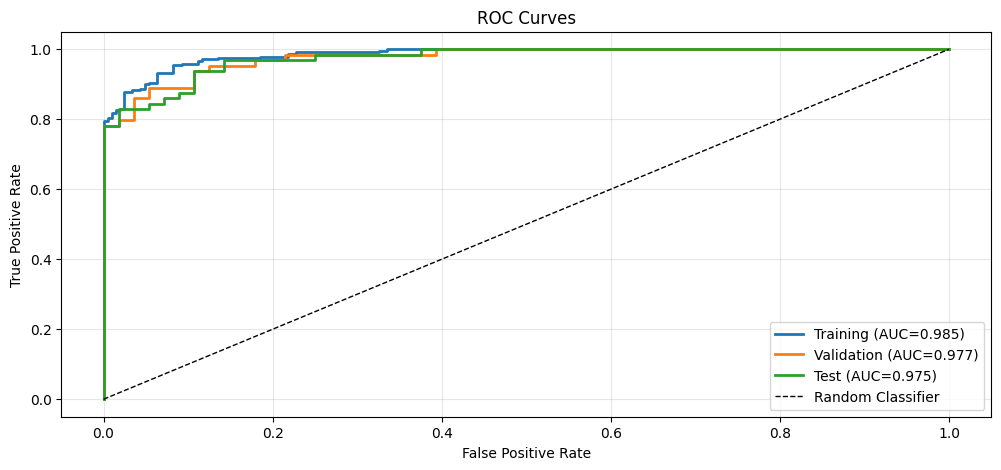

In [15]:
# Plot ROC curves
plt.figure(figsize=(12, 5))

for name, y_true, y_prob in [
    ("Training", y_train, y_train_prob),
    ("Validation", y_val, y_val_prob),
    ("Test", y_test, y_test_prob)
]:
    try:
        fpr, tpr, _ = roc_curve(y_true.flatten(), y_prob.flatten())
        auc = roc_auc_score(y_true.flatten(), y_prob.flatten())
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", linewidth=2)
    except:
        pass

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [16]:
# Try different regularization strengths
lambda_values = [0, 0.01, 0.001, 0.1, 1, 10]
all_results = []
model_counter = 0
total_models = len(data_versions) * len(lambda_values)

print(f"\n{'='*80}")
print(f"TRAINING {total_models} MODELS (4 feature transformations × {len(lambda_values)} regularization values)")
print(f"{'='*80}\n")

for version_name, (suffix, version_desc) in data_versions.items():
    print(f"\n{'='*80}")
    print(f"Feature Transformation: {version_desc}")
    print(f"{'='*80}")
    
    # Use this version's data
    X_train = X_data[version_name]['train']
    X_val = X_data[version_name]['val']
    X_test = X_data[version_name]['test']
    
    # Augment X with column of ones for bias term
    X_train_aug = augment_X(X_train)
    X_val_aug = augment_X(X_val)
    X_test_aug = augment_X(X_test)
    
    for lambda_reg in lambda_values:
        model_counter += 1
        model_name = f"{version_name}_lambda_{lambda_reg}"
        
        # Train with this lambda
        w_tune, _ = Gradient_Ascent(
            X_train_aug, 
            y_train, 
            learning_rate, 
            num_iters, 
            lambda_reg=lambda_reg,
            verbose=False
        )
        
        # Evaluate on test set
        y_test_pred = predict_class(X_test_aug, w_tune, threshold)
        y_test_prob = hypothesis(X_test_aug, w_tune)
        test_precision, test_recall = precision_recall(y_test_pred, y_test, threshold)
        test_f1 = f1_score(test_precision, test_recall)
        test_accuracy = np.mean(y_test_pred.flatten() == y_test.flatten())
        
        # Calculate test AUC
        try:
            test_auc = roc_auc_score(y_test.flatten(), y_test_prob.flatten())
        except:
            test_auc = 0
        
        # Save model weights
        np.save(f"{MODEL_PATH}/{model_name}.npy", w_tune)
        
        # Store results
        results = {
            'model_id': f"{model_counter:02d}",
            'version': version_name,
            'version_desc': version_desc,
            'regularization': f"lambda_{lambda_reg}",
            'lambda': lambda_reg,
            'test_acc': test_accuracy,
            'test_auc': test_auc,
            'test_f1': test_f1,
            'test_recall': test_recall,
            'test_precision': test_precision
        }
        
        all_results.append(results)
        print(f"  Lambda={lambda_reg:6.3f}: Acc={test_accuracy:.4f}, AUC={test_auc:.4f}, F1={test_f1:.4f}")
    
    print()

print("Training complete")

# Save results to CSV
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('test_auc', ascending=False)
results_df.to_csv(f"{RESULTS_PATH}/model_results.csv", index=False)

print(f"\n{'='*80}")
print("DETAILED RESULTS: All Models")
print(f"{'='*80}")
print(results_df[['model_id', 'version_desc', 'regularization', 'test_acc', 'test_auc', 'test_f1']].to_string(index=False))

# Find best model based on AUC score
best_idx = results_df['test_auc'].idxmax()
best_version = results_df.loc[best_idx, 'version']
best_version_desc = results_df.loc[best_idx, 'version_desc']
best_lambda = results_df.loc[best_idx, 'lambda']
best_auc = results_df.loc[best_idx, 'test_auc']

print(f"\n{'='*80}")
print(f"Best model (selected by AUC score): {best_version_desc}, Lambda={best_lambda} (AUC={best_auc:.4f})")
print(f"{'='*80}")
print(f"Test metrics at best model:")
print(f"  Accuracy: {results_df.loc[best_idx, 'test_acc']:.4f}")
print(f"  Precision: {results_df.loc[best_idx, 'test_precision']:.4f}")
print(f"  Recall: {results_df.loc[best_idx, 'test_recall']:.4f}")
print(f"  F1 Score: {results_df.loc[best_idx, 'test_f1']:.4f}")
print(f"  AUC: {results_df.loc[best_idx, 'test_auc']:.4f}")



TRAINING 24 MODELS (4 feature transformations × 6 regularization values)


Feature Transformation: Baseline (untransformed)
  Lambda= 0.000: Acc=0.9000, AUC=0.9749, F1=0.9118
  Lambda= 0.010: Acc=0.8917, AUC=0.9754, F1=0.9051
  Lambda= 0.001: Acc=0.9000, AUC=0.9749, F1=0.9118
  Lambda= 0.100: Acc=0.8250, AUC=0.9749, F1=0.8571
  Lambda= 1.000: Acc=0.7083, AUC=0.9710, F1=0.7853
  Lambda=10.000: Acc=0.5500, AUC=0.9562, F1=0.7033


Feature Transformation: Polynomial degree 2
  Lambda= 0.000: Acc=0.7250, AUC=0.9107, F1=0.7950
  Lambda= 0.010: Acc=0.7167, AUC=0.9093, F1=0.7901
  Lambda= 0.001: Acc=0.7250, AUC=0.9110, F1=0.7950
  Lambda= 0.100: Acc=0.7083, AUC=0.9032, F1=0.7853
  Lambda= 1.000: Acc=0.6333, AUC=0.8359, F1=0.7442
  Lambda=10.000: Acc=0.5333, AUC=0.7028, F1=0.6957


Feature Transformation: Polynomial degree 3
  Lambda= 0.000: Acc=0.8833, AUC=0.9450, F1=0.8923
  Lambda= 0.010: Acc=0.8917, AUC=0.9450, F1=0.9008
  Lambda= 0.001: Acc=0.8833, AUC=0.9450, F1=0.8923
  Lambda= 0.100: A

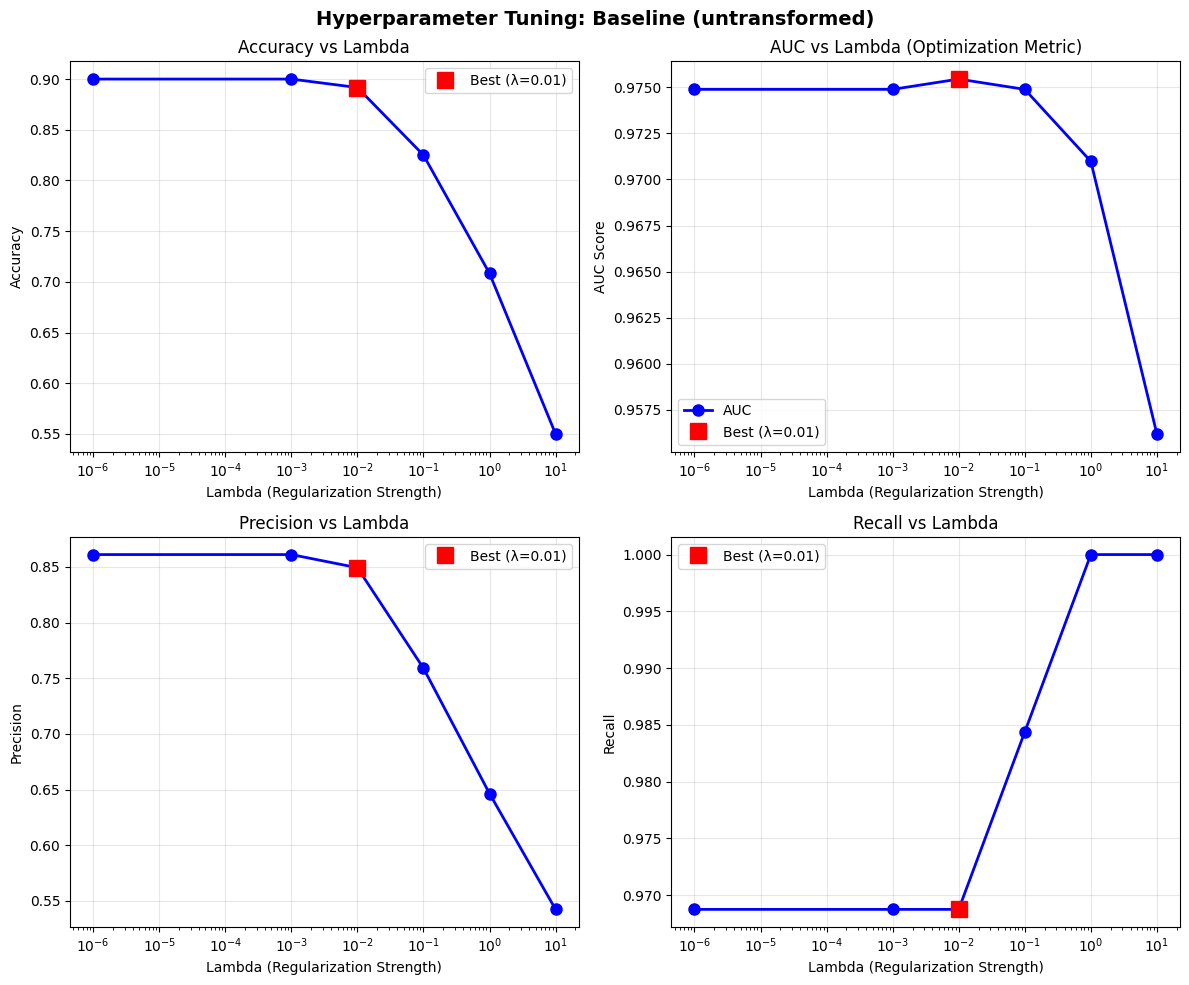

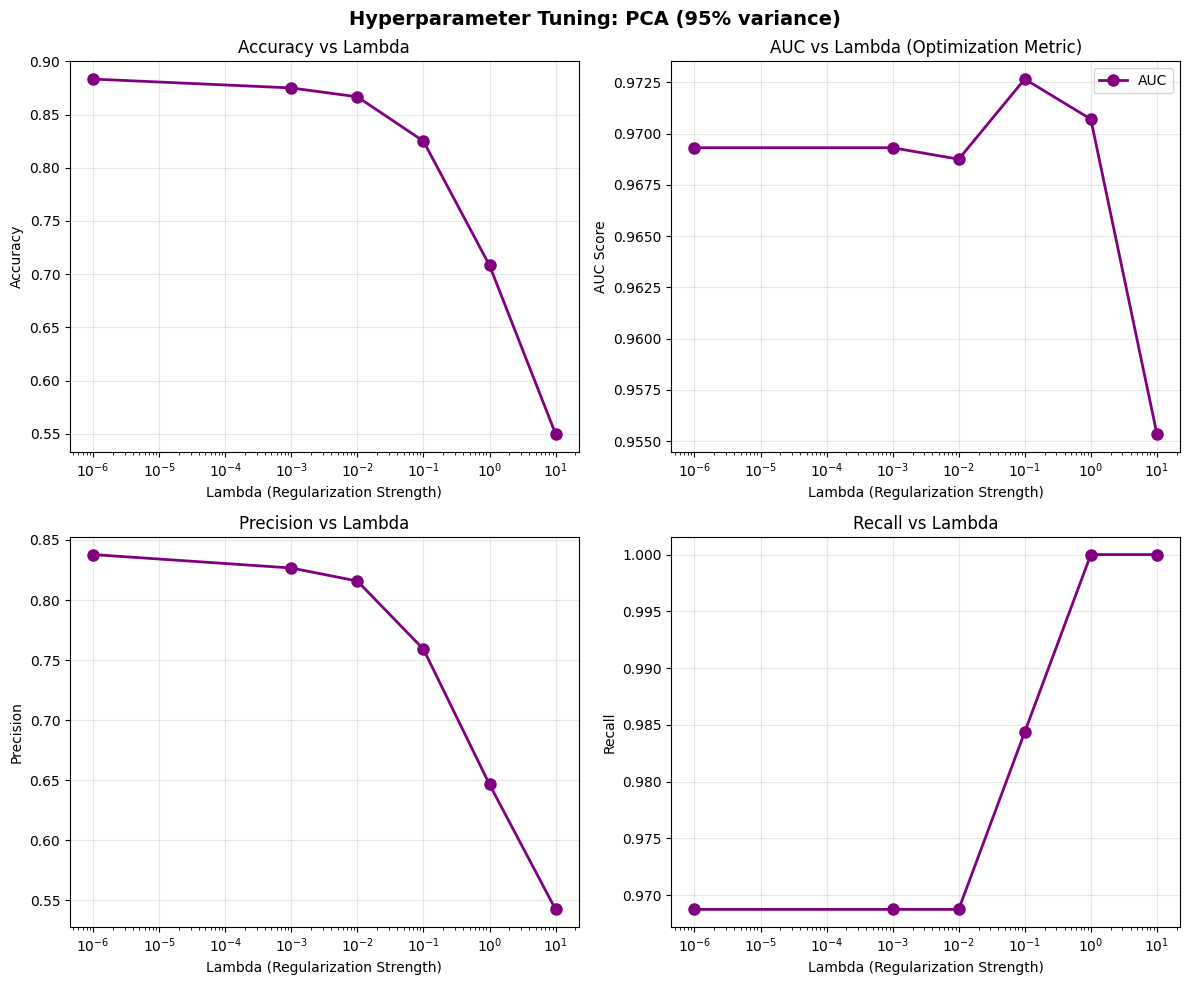

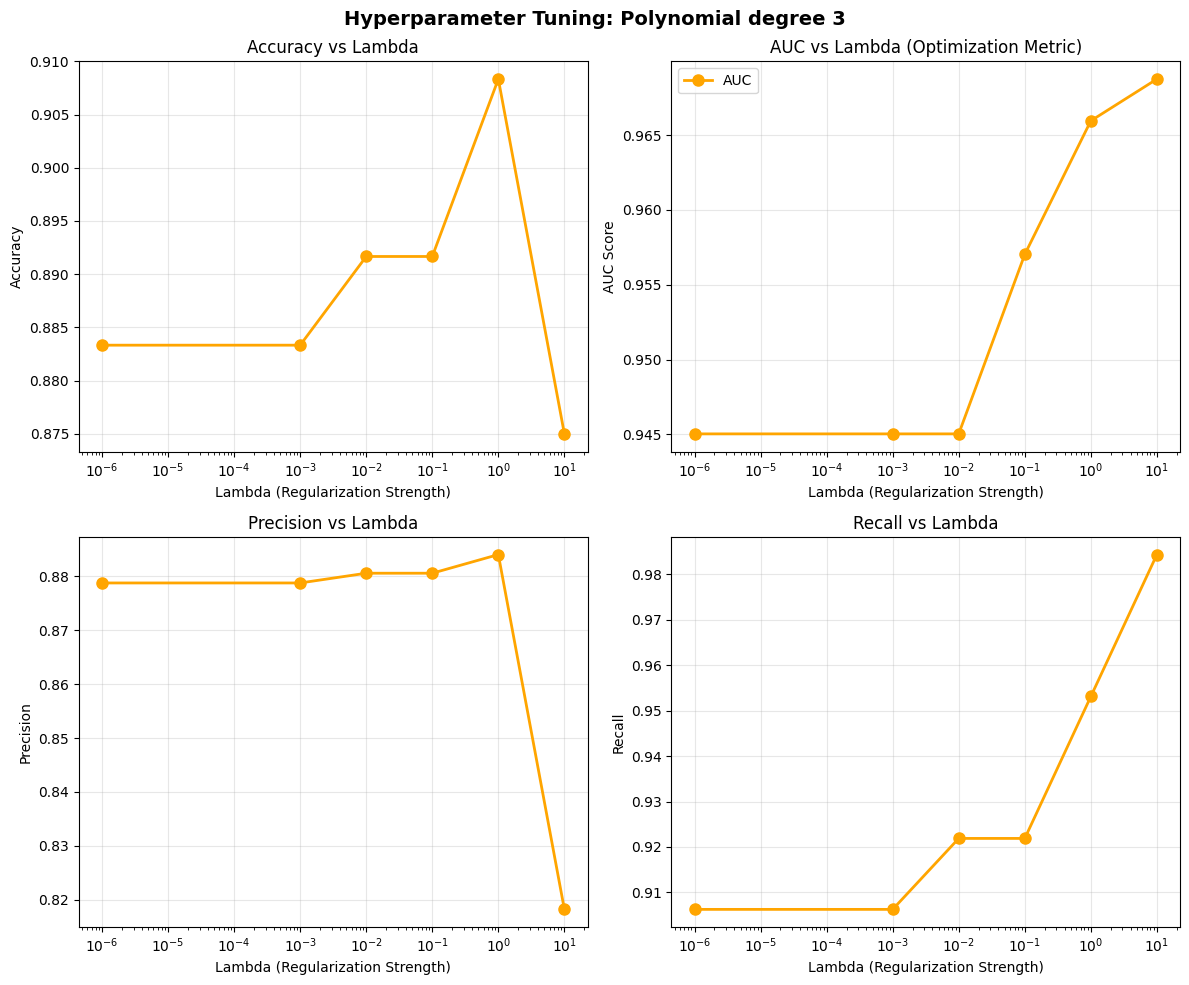

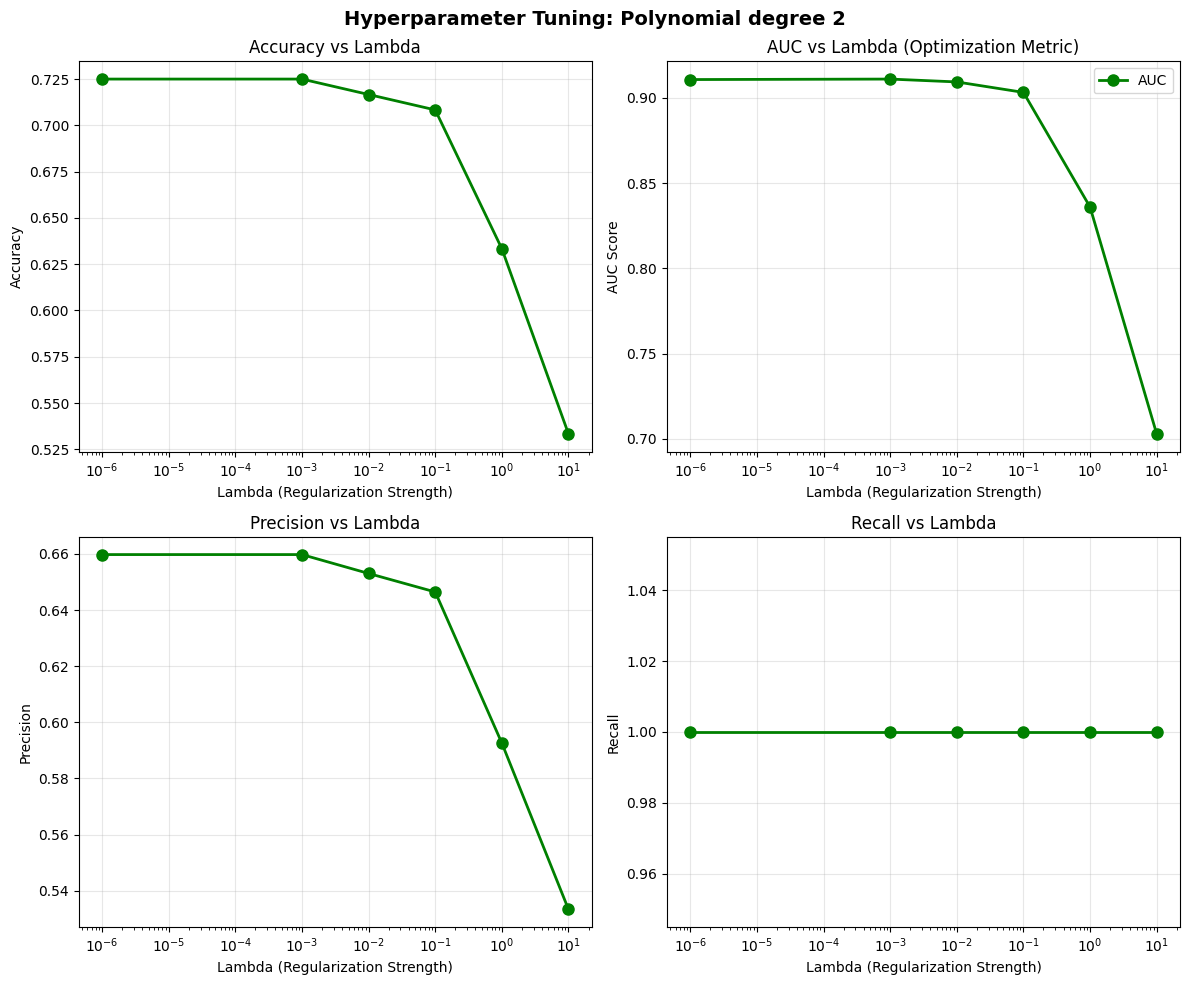

In [17]:
# Plot hyperparameter tuning results - one figure per feature transformation
version_colors = {
    'Baseline (untransformed)': 'blue',
    'Polynomial degree 2': 'green',
    'Polynomial degree 3': 'orange',
    'PCA (95% variance)': 'purple'
}

# Create one figure per version
for version_desc in results_df['version_desc'].unique():
    version_data = results_df[results_df['version_desc'] == version_desc].copy()
    version_data['plot_lambda'] = version_data['lambda'].apply(lambda x: 1e-6 if x == 0 else x)
    version_data = version_data.sort_values('plot_lambda')
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Hyperparameter Tuning: {version_desc}', fontsize=14, fontweight='bold')
    
    # Check if this version has the best lambda
    is_best_version = (version_data['version_desc'].iloc[0] == best_version_desc)
    if is_best_version:
        best_plot_lambda = version_data[version_data['lambda'] == best_lambda]['plot_lambda'].values[0]
        best_auc_plot = version_data[version_data['lambda'] == best_lambda]['test_auc'].values[0]
    
    color = version_colors[version_desc]
    
    # Accuracy plot
    axes[0, 0].plot(version_data['plot_lambda'], version_data['test_acc'], 'o-', linewidth=2, markersize=8, color=color)
    if is_best_version:
        best_acc_plot = version_data[version_data['lambda'] == best_lambda]['test_acc'].values[0]
        axes[0, 0].plot(best_plot_lambda, best_acc_plot, 's', markersize=12, color='red', label=f'Best (λ={best_lambda})', zorder=5)
        axes[0, 0].legend()
    axes[0, 0].set_xlabel('Lambda (Regularization Strength)')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Accuracy vs Lambda')
    axes[0, 0].set_xscale('log')
    axes[0, 0].grid(True, alpha=0.3)
    
    # AUC plot (optimization metric) - highlight best point
    axes[0, 1].plot(version_data['plot_lambda'], version_data['test_auc'], 'o-', linewidth=2, markersize=8, color=color, label='AUC')
    if is_best_version:
        axes[0, 1].plot(best_plot_lambda, best_auc_plot, 's', markersize=12, color='red', label=f'Best (λ={best_lambda})', zorder=5)
    axes[0, 1].set_xlabel('Lambda (Regularization Strength)')
    axes[0, 1].set_ylabel('AUC Score')
    axes[0, 1].set_title('AUC vs Lambda (Optimization Metric)')
    axes[0, 1].set_xscale('log')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # Precision plot
    axes[1, 0].plot(version_data['plot_lambda'], version_data['test_precision'], 'o-', linewidth=2, markersize=8, color=color)
    if is_best_version:
        best_prec_plot = version_data[version_data['lambda'] == best_lambda]['test_precision'].values[0]
        axes[1, 0].plot(best_plot_lambda, best_prec_plot, 's', markersize=12, color='red', label=f'Best (λ={best_lambda})', zorder=5)
        axes[1, 0].legend()
    axes[1, 0].set_xlabel('Lambda (Regularization Strength)')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision vs Lambda')
    axes[1, 0].set_xscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall plot
    axes[1, 1].plot(version_data['plot_lambda'], version_data['test_recall'], 'o-', linewidth=2, markersize=8, color=color)
    if is_best_version:
        best_rec_plot = version_data[version_data['lambda'] == best_lambda]['test_recall'].values[0]
        axes[1, 1].plot(best_plot_lambda, best_rec_plot, 's', markersize=12, color='red', label=f'Best (λ={best_lambda})', zorder=5)
        axes[1, 1].legend()
    axes[1, 1].set_xlabel('Lambda (Regularization Strength)')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].set_title('Recall vs Lambda')
    axes[1, 1].set_xscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [18]:
# Train final model with best lambda (selected by AUC score on test set)
# Use best version's data
X_train = X_data[best_version]['train']
X_val = X_data[best_version]['val']
X_test = X_data[best_version]['test']

# Augment X with column of ones for bias term
X_train_aug = augment_X(X_train)
X_val_aug = augment_X(X_val)
X_test_aug = augment_X(X_test)

print(f"Training final model: {best_version_desc}, Lambda={best_lambda} (AUC={best_auc:.4f} on test)")
w_final, _ = Gradient_Ascent(
    X_train_aug, 
    y_train, 
    learning_rate, 
    num_iters, 
    lambda_reg=best_lambda,
    verbose=False
)

# Evaluate on test set
y_test_pred_final = predict_class(X_test_aug, w_final, threshold)
y_test_prob_final = hypothesis(X_test_aug, w_final)

precision, recall = precision_recall(y_test_pred_final, y_test, threshold)
f1 = f1_score(precision, recall)
accuracy = np.mean(y_test_pred_final.flatten() == y_test.flatten())

# Calculate AUC
try:
    test_auc = roc_auc_score(y_test.flatten(), y_test_prob_final.flatten())
except:
    test_auc = 0

print("\nFinal Test Set Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {test_auc:.4f}")

cm = confusion_matrix(y_test.flatten(), y_test_pred_final.flatten())
print(f"\nConfusion Matrix:")
print(cm)


Training final model: Baseline (untransformed), Lambda=0.01 (AUC=0.9754 on test)

Final Test Set Results:
Accuracy: 0.8917
Precision: 0.8493
Recall: 0.9688
F1 Score: 0.9051
AUC: 0.9754

Confusion Matrix:
[[45 11]
 [ 2 62]]


In [ ]:
# Confusion Matrix Heatmap for Best Logistic Regression Model
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Non-Playoff', 'Playoff'],
            yticklabels=['Non-Playoff', 'Playoff'])
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.title(
    f'Confusion Matrix - Best Logistic Regression Model\n{best_version_desc}, Lambda={best_lambda}',
    fontweight='bold'
)
plt.show()


In [19]:
print("\n" + "=" * 80)
print("\n" + "=" * 80)
print("DETAILED RESULTS: All Lambda Values Across All Feature Transformations (Test Set)")
print("=" * 80)
print("(Best model selected based on AUC)")
print("=" * 80)
print(results_df[['version_desc', 'lambda', 'test_acc', 'test_precision', 'test_recall', 'test_f1', 'test_auc']].sort_values('test_auc', ascending=False).to_string(index=False))

print("\n" + "=" * 80)
print("PERFORMANCE BY FEATURE TRANSFORMATION")
print("=" * 80)
version_stats = results_df.groupby('version_desc').agg({
    'test_acc': ['mean', 'std', 'min', 'max'],
    'test_precision': ['mean', 'std', 'min', 'max'],
    'test_recall': ['mean', 'std', 'min', 'max'],
    'test_f1': ['mean', 'std', 'min', 'max'],
    'test_auc': ['mean', 'std', 'min', 'max']
}).round(4)
print(version_stats)

print("\n" + "=" * 80)
print("PERFORMANCE BY LAMBDA")
print("=" * 80)
lambda_stats = results_df.groupby('lambda').agg({
    'test_acc': ['mean', 'std', 'min', 'max'],
    'test_auc': ['mean', 'std', 'min', 'max'],
    'test_f1': ['mean', 'std', 'min', 'max'],
    'test_precision': ['mean', 'std', 'min', 'max'],
    'test_recall': ['mean', 'std', 'min', 'max']
}).round(4)
print(lambda_stats)



DETAILED RESULTS: All Lambda Values Across All Feature Transformations (Test Set)
(Best model selected based on AUC)
            version_desc  lambda  test_acc  test_precision  test_recall  test_f1  test_auc
Baseline (untransformed)   0.010  0.891667        0.849315     0.968750 0.905109  0.975446
Baseline (untransformed)   0.000  0.900000        0.861111     0.968750 0.911765  0.974888
Baseline (untransformed)   0.001  0.900000        0.861111     0.968750 0.911765  0.974888
Baseline (untransformed)   0.100  0.825000        0.759036     0.984375 0.857143  0.974888
      PCA (95% variance)   0.100  0.825000        0.759036     0.984375 0.857143  0.972656
Baseline (untransformed)   1.000  0.708333        0.646465     1.000000 0.785276  0.970982
      PCA (95% variance)   1.000  0.708333        0.646465     1.000000 0.785276  0.970703
      PCA (95% variance)   0.001  0.875000        0.826667     0.968750 0.892086  0.969308
      PCA (95% variance)   0.000  0.883333        0.837838    